# Charts Deforestation

## 0. Reading data

In [1]:
from runner import io
import altair as alt
pantanal_deforestation_df = io.load_table("domain", "deforestation")
pantanal_df = io.load_table("domain", "pantanal")
df_land_use = io.load_table("raw", "land_use")

In [2]:
pantanal_deforestation_df.head()

,city,location_UF,location,year,from_class,to_class,deforestation_ha
0,Aquidauana,MS,Aquidauana (MS),1985-01-01,304,1134,14445.862874
1,Aquidauana,MS,Aquidauana (MS),1986-01-01,304,1134,14026.138228
2,Aquidauana,MS,Aquidauana (MS),1987-01-01,304,1134,15730.481323
3,Aquidauana,MS,Aquidauana (MS),1988-01-01,304,1134,9578.366320
4,Aquidauana,MS,Aquidauana (MS),1989-01-01,304,1134,19906.438819


In [3]:
pantanal_df

,location,year,crop,area_ha,type,quantidade_ton,numero_cabecas,delta_ha,delta_quantidade_ton,delta_nb_heads
0,Aquidauana (MS),1985,Cana-de-açúcar,NaN,temporario,4200.0,NaN,0.0,0.0,0.0
1,Bodoquena (MS),1985,Cana-de-açúcar,NaN,temporario,1200.0,NaN,0.0,0.0,0.0
2,Corumbá (MS),1985,Cana-de-açúcar,NaN,temporario,600.0,NaN,0.0,0.0,0.0
3,Coxim (MS),1985,Cana-de-açúcar,NaN,temporario,200.0,NaN,0.0,0.0,0.0
4,Ladário (MS),1985,Cana-de-açúcar,NaN,temporario,90.0,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3435,Sonora (MS),2018,Others_temporario,15.0,None,150.0,NaN,0.0,0.0,0.0
3436,Sonora (MS),2019,Others_permanente,0.0,None,0.0,NaN,0.0,0.0,0.0
3437,Sonora (MS),2019,Others_temporario,315.0,None,1425.0,NaN,300.0,1275.0,0.0
3438,Sonora (MS),2020,Others_permanente,0.0,None,0.0,NaN,0.0,0.0,0.0


## 1. Config Altair

In [4]:
# Databricks notebook source
# MAGIC %md # Altair setup

# COMMAND ----------

# MAGIC %sh
# MAGIC # Installing altair
# MAGIC /databricks/python/bin/pip install altair altair_saver selenium -q
# MAGIC 
# MAGIC # Installing chromewebdriver for saving altair plots
# MAGIC apt-get update -y
# MAGIC apt-get install -y chromium-browser chromium-chromedriver

# COMMAND ----------

from datetime import datetime, timedelta
import json

import pandas as pd
import numpy as np

import altair as alt
alt.data_transformers.disable_max_rows()
alt.renderers.set_embed_options(scaleFactor=5)

# COMMAND ----------

# Altair theme setup
def tfg_palette(key="tfg_dark_light"):
    color_schemes = {
        'category-6': ['#ec8431', '#829eb1', '#c89d29', '#3580b1', '#adc839', '#ab7fb4'],
        'fire-7': ['#fbf2c7', '#f9e39c', '#f8d36e', '#f4bb6a', '#e68a4f', '#d15a40', '#ab4232'],
        'fireandice-6': ['#e68a4f', '#f4bb6a', '#f9e39c', '#dadfe2', '#a6b7c6', '#849eae'],
        'ice-7': ['#edefee', '#dadfe2', '#c4ccd2', '#a6b7c6', '#849eae', '#607785', '#47525d'],
        "tfg_dark": ['#0C66B5', '#BA1D32', '#0F8E40', '#E56F20', '#862BAF', '#626D69', '#ED5087'],
        "tfg_light": ['#3DB9E2', '#51DB63', '#E26868', '#FFB270', '#B37CEA', '#A8A1A4', '#FF87CD'],
    }
    
    color_schemes["tfg_dark_light"] = color_schemes["tfg_dark"] + color_schemes["tfg_light"]
    
    return color_schemes[key]

def science_theme_title(
    font="Helvetica Neue",
    titleFontSize=18,
    subtitleFontSize=14,
    titleFontWeight="normal",
    text=None,
    subtitle=None,
    **kwargs
):
    title_dict = {
        "align": "left",
        "anchor": "start",
        "frame": "group",
        "font": font,
        "fontSize": titleFontSize,
        "dy": -2,
        # Doesn't work directly in config
        "subtitleFont": font,
        "subtitleFontSize": subtitleFontSize,
        "fontWeight": titleFontWeight,
    }
    
    if text is not None:
        title_dict["text"] = text

    if subtitle is not None:
        title_dict["subtitle"] = subtitle
    
    if kwargs:
        title_dict.update(kwargs)

    return title_dict

def science_theme(
    width=1600/3,
    height=900/3,
    font="Helvetica Neue",
    titleFontSize=18,
    titleFontWeight="bold",
    subtitleFontSize=14,
    baseFontSize=14,
):    

    return {
        "config": {
            "view": {
                "width": width,
                "height": height,
                "fill": "white",
            },
            "title": science_theme_title(
                font=font,
                titleFontSize=titleFontSize,
                subtitleFontSize=subtitleFontSize,
            ),
            "axis": {
                "domainColor": "lightGrey",
                "gridColor": "lightGrey",
                "gridWidth": 0.25,
#                 "title": None,
                "titleFont": font,
                "titleFontSize": baseFontSize - 3,
                "labelFont": font,
                "labelFontSize": baseFontSize,
            },
            "legend": {
                "layout": {"anchor": "start"},
                "labelLimit": 0,
                "titleFontSize": baseFontSize,
                "titleFont": font,
                "labelFontSize": baseFontSize,
                "labelFont": font,
            },
            "header": {
                "title": None,
                "titleFont": font,
                "labelFont": font,
                "labelFontSize": baseFontSize,
                "labelPadding": 2,
            },
            "range": {
                "category": tfg_palette(),
            },
        }
    }

def science_theme_caption(text):
    return (
        alt.Chart(pd.DataFrame(),
                  title={"text": text, **science_theme_title(titleFontSize=12, titleFontWeight="normal")})
        .mark_text()
        .properties(height=1, view={"stroke": None})
    )

def science_theme_facet_title_background(width, fill="lightGrey", opacity=0.25, widthExtra=1):
    return (
        alt.Chart(pd.DataFrame({"a": [0]}))
        .mark_rect(fill=fill, opacity=opacity)
        .encode(y=alt.value(-25), y2=alt.value(-1), x=alt.value(0), x2=alt.value(width + widthExtra))
    )

def science_theme_facet_plot(chart, 
                             title=None, subtitle=None, caption=None,
                             width=300, height=150,
                             facet_kwargs=None, facet_resolve_scales=None,
                             focus_chart=None, focus_chart_width=300, focus_chart_height=150,
                             focus_chart_title="All",
                             focus_chart_resolve_scales=None,
                             grey_facet_background=True,
                             configure_headerColumn=True,
                             **kwargs):
    
    if facet_kwargs is not None:
        if grey_facet_background:
          chart = (chart + science_theme_facet_title_background(width=width))
        chart = chart.facet(**facet_kwargs)

        if facet_resolve_scales is not None:
          chart = chart.resolve_scale(**facet_resolve_scales)
        
        if focus_chart is not None:
            if grey_facet_background: 
              focus_chart = focus_chart + science_theme_facet_title_background(width=focus_chart_width)
            focus_chart = focus_chart.properties(
                width=focus_chart_width, 
                height=focus_chart_height,
                title=science_theme_title(text=focus_chart_title, titleFontSize=14, anchor="middle", offset=-22 if grey_facet_background else 0)
            )
            chart = focus_chart | chart
            
            if focus_chart_resolve_scales is not None:
              chart = chart.resolve_scale(**focus_chart_resolve_scales)
    
    chart = (
        (chart
         # Adding caption
         & science_theme_caption(caption)).resolve_scale(
            x="independent", y="independent", size="independent",
            color="independent", fill="independent", stroke="independent", opacity="independent",
        )
        # Adding title and subtitle
        .properties(title=science_theme_title(text=title, subtitle=subtitle))
        # Configuring plot size
        .configure_view(width=width, height=height)
    )
    
    if (facet_kwargs is not None) and grey_facet_background and configure_headerColumn:
        chart = chart.configure_headerColumn(labelPadding=-20).configure_headerFacet(labelPadding=-20)
    
    return chart
  
def science_theme_weekly_highlights(format="%b %d", tickCount=40): 
    return alt.Axis(
        format=format,
        tickCount=tickCount,
        gridOpacity=alt.condition(
            alt.Predicate(alt.FieldEqualPredicate(field='value', timeUnit="day", equal=1)),
            alt.value(1.0),
            alt.value(0.4)
        ),
    )
    
alt.themes.register("science_theme", science_theme)
alt.themes.enable("science_theme")

# COMMAND ----------

# DBTITLE 1,Test the saver works with a sample graph save
# import altair_saver
# import pandas as pd

# test_path = '/dbfs/mnt/tfg-ua/airflow/creatives/altair_test_save.png'

# source = pd.DataFrame({'x': ['A'], 'y': [1]})
# chart = alt.Chart(source).mark_bar().encode(x='x', y='y')
# try:
#   chart.save(test_path)
# except ValueError as e:
#   if 'No enabled saver found' in str(e):
#     # retry with an explicit method + driver to provide a more informative error message
#     altair_saver.save(chart, test_path, method='selenium', webdriver='chrome')
#   raise e  # in case the more explicit method works for some reason, or this is an unrecognized error



ThemeRegistry.enable('science_theme')

## 2. Deforestation Analysis

### 2.1 Evolution Deforestation

In [5]:
pantanal_deforestation_df

,city,location_UF,location,year,from_class,to_class,deforestation_ha
0,Aquidauana,MS,Aquidauana (MS),1985-01-01,304,1134,14445.862874
1,Aquidauana,MS,Aquidauana (MS),1986-01-01,304,1134,14026.138228
2,Aquidauana,MS,Aquidauana (MS),1987-01-01,304,1134,15730.481323
3,Aquidauana,MS,Aquidauana (MS),1988-01-01,304,1134,9578.366320
4,Aquidauana,MS,Aquidauana (MS),1989-01-01,304,1134,19906.438819
...,...,...,...,...,...,...,...
571,Sonora,MS,Sonora (MS),2016-01-01,264,999,1864.663098
572,Sonora,MS,Sonora (MS),2017-01-01,264,999,1765.371164
573,Sonora,MS,Sonora (MS),2018-01-01,264,999,1760.021683
574,Sonora,MS,Sonora (MS),2019-01-01,264,999,2371.518044


In [6]:
qntd_deforestation_chart = alt.Chart(pantanal_deforestation_df).mark_area(opacity=0.55).encode(
    x=alt.X('year:T', axis=alt.Axis(title="Year")),
    y=alt.Y('deforestation_ha:Q', axis=alt.Axis(title="Deforestation (ha)")),
    color='location',
#     opacity='location_UF:O'
)

# qntd_total_deforestation_chart = alt.Chart(pantanal_deforestation_df).mark_point(color='red').encode(
#     x='year:T',
#     y='sum_deforestation:Q',
# #     color='location',
# #     opacity='location_UF:O'
# ).transform_aggregate(
#     sum_deforestation='sum(deforestation_ha)',
#     groupby=[
#         "year", 
#     ]
# )

final_chart = qntd_deforestation_chart.properties(
    width=700,
    height=500
).properties(
    title=science_theme_title(
        text="Evolution of deforestation by municipality in Pantanal", 
        subtitle="1985-2020"
    )
)

final_chart

alt.Chart(...)

In [7]:
# qntd_deforestation_chart = alt.Chart(pantanal_deforestation_df).mark_area(opacity=0.7).encode(
#     x='year:T',
#     y=alt.Y('deforestation_ha:Q', stack='normalize'),
#     color='location',
# #     opacity='location_UF:O'
# )

# (qntd_deforestation_chart).properties(
#     width=800,
#     height=550
# )

In [8]:
qntd_deforestation_chart = alt.Chart(pantanal_deforestation_df).mark_area(opacity=0.7).encode(
    x='year:T',
    y='sum_deforestation:Q',
    color='location_UF',
#     opacity='location_UF:O'
).transform_aggregate(
    sum_deforestation='sum(deforestation_ha)',
    groupby=[
        "year", 
#         "location",
        "location_UF"
    ]
)

(qntd_deforestation_chart).properties(
    width=800,
    height=550
)

alt.Chart(...)

In [9]:
qntd_deforestation_chart = alt.Chart(pantanal_deforestation_df).mark_area(opacity=0.7).encode(
    x='year:T',
    y=alt.Y('sum_deforestation:Q', stack='normalize'),
    color='location_UF',
#     opacity='location_UF:O'
).transform_aggregate(
    sum_deforestation='sum(deforestation_ha)',
    groupby=[
        "year", 
#         "location",
        "location_UF"
    ]
)

(qntd_deforestation_chart).properties(
    width=800,
    height=550
)

alt.Chart(...)

### 2.2 Charts correlation deforestation & production

In [10]:
pantanal_df.groupby(['crop']).sum().reset_index().sort_values('quantidade_ton', ascending=False)

,crop,area_ha,quantidade_ton,numero_cabecas,delta_ha,delta_quantidade_ton,delta_nb_heads
1,Cana-de-açúcar,868635.0,60470257.0,0.0,70771.0,6440993.0,0.0
5,Soja (em grão),7961848.0,23729442.0,0.0,463559.0,1652933.0,0.0
2,Milho (em grão),2556605.0,11400323.0,0.0,306679.0,2025847.0,0.0
4,Others_temporario,1406976.0,6246822.0,0.0,241471.0,767653.0,0.0
3,Others_permanente,11410.0,488317.0,0.0,1996.0,56427.0,0.0
0,Bovino,0.0,0.0,235262080.0,0.0,0.0,7760612.0


In [11]:
pantanal_df['year'] = pd.to_datetime(pantanal_df['year'])

In [12]:
complete_df = pantanal_deforestation_df[['location', 'year', 'deforestation_ha']].merge(
    pantanal_df,
    on=['location', 'year'],
    how='left'
)

In [13]:
main_cultures = ['Cana-de-açúcar', 'Soja (em grão)', 'Milho (em grão)']
main_cultures_complete_df = complete_df[complete_df.crop.isin(main_cultures)]

In [14]:
main_cultures_complete_df.corr()

,deforestation_ha,area_ha,quantidade_ton,numero_cabecas,delta_ha,delta_quantidade_ton,delta_nb_heads
deforestation_ha,1.000000,-0.070293,-0.133905,NaN,-0.031916,-0.071985,NaN
area_ha,-0.070293,1.000000,0.458390,NaN,0.517678,0.195031,NaN
quantidade_ton,-0.133905,0.458390,1.000000,NaN,0.245282,0.536272,NaN
numero_cabecas,NaN,NaN,NaN,NaN,NaN,NaN,NaN
delta_ha,-0.031916,0.517678,0.245282,NaN,1.000000,0.385374,NaN
delta_quantidade_ton,-0.071985,0.195031,0.536272,NaN,0.385374,1.000000,NaN
delta_nb_heads,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
main_cultures_complete_df.rename(
    columns={
        'area_ha': 'Production Area (ha)',
        'deforestation_ha': 'Deforestation Area (ha)',
        'quantidade_ton': 'Production volume (ton)'
    },
    inplace=True
)

/var/folders/15/swv8hztj3m331bbjtnrdtvfw0000gn/T/ipykernel_98914/181077010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_cultures_complete_df.rename(


In [16]:
main_cultures_complete_df.columns

Index(['location', 'year', 'Deforestation Area (ha)', 'crop',
       'Production Area (ha)', 'type', 'Production volume (ton)',
       'numero_cabecas', 'delta_ha', 'delta_quantidade_ton', 'delta_nb_heads'],
      dtype='object')

In [17]:
corr_chart = alt.Chart(main_cultures_complete_df).mark_point(size=17).encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='crop:N',
    opacity='location_UF:N'
).properties(
    width=150,
    height=150
).repeat(
    row=['Production Area (ha)', 'Deforestation Area (ha)', 'Production volume (ton)'],
    column=['Production volume (ton)', 'Deforestation Area (ha)', 'Production Area (ha)']
)


final_chart = corr_chart.properties(
    title=science_theme_title(
        text="Pair plot between Production Area, Production Quantity and Deforestation", 
        subtitle="1985-2020"
    )
).configure_range(
    category={'scheme': 'dark2'}
)

final_chart

alt.RepeatChart(...)

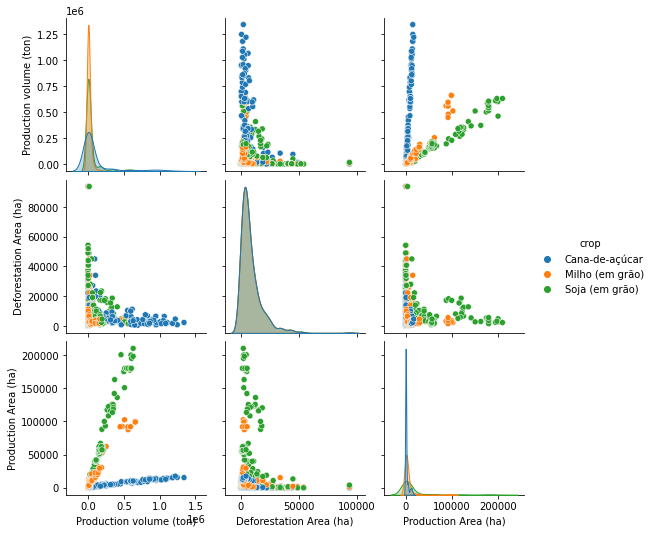

In [18]:
import seaborn as sns 
sns.pairplot(main_cultures_complete_df[['Production volume (ton)', 'Deforestation Area (ha)', 'Production Area (ha)', 'crop']], hue='crop')

In [19]:
pantanal_df_pecuaria = pantanal_df.query('type == "pecuaria"')
pantanal_df_pecuaria['year'] = pd.to_datetime(pantanal_df_pecuaria['year'])
complete_df_pecuaria = pantanal_deforestation_df[['location', 'year', 'deforestation_ha']].merge(
    pantanal_df_pecuaria,
    on=['location', 'year'],
    how='left'
)
complete_df_pecuaria['numero_cabecas'] = complete_df_pecuaria['numero_cabecas'].astype('float')

/var/folders/15/swv8hztj3m331bbjtnrdtvfw0000gn/T/ipykernel_98914/1373358172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pantanal_df_pecuaria['year'] = pd.to_datetime(pantanal_df_pecuaria['year'])


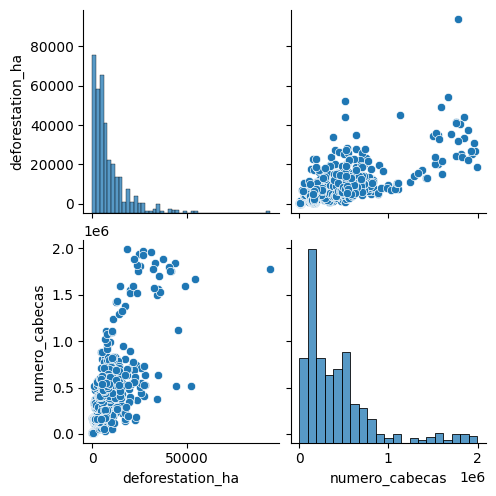

In [20]:
sns.pairplot(complete_df_pecuaria[['deforestation_ha', 'numero_cabecas']])

In [21]:
chart = alt.Chart(complete_df_pecuaria).mark_point(color='green').encode(
    x=alt.X('numero_cabecas', axis=alt.Axis(title='Number of livestock heads')),
    y=alt.Y('deforestation_ha', axis=alt.Axis(title='Deforestation (ha)')),
)

reg_chart = (
    chart + 
    chart.transform_regression(
        'numero_cabecas', 'deforestation_ha'
    ).mark_line(
        color='red', strokeDash=[2]
    )
)

text = alt.Chart({'values':[{}]}).mark_text(
    align="left", baseline="top", size=15, color='red', angle=350
).encode(
    x=alt.value(400),  # pixels from left
    y=alt.value(370),  # pixels from top
    text=alt.value("y = 2337.35 + 0.0039 * x"))

text2 = alt.Chart({'values':[{}]}).mark_text(
    align="left", baseline="top", size=15, color='red',
).encode(
    x=alt.value(20),  # pixels from left
    y=alt.value(20),  # pixels from top
    text=alt.value("R^2 = 9.74%"))

reg_chart = reg_chart + text + text2

final_chart = reg_chart.properties(
    width=750,
    height=500,
    title=science_theme_title(
        text="Linear regression of Deforestation X Number of livestock heads", 
        subtitle="1985-2020"
    )
)

final_chart

alt.LayerChart(...)

In [22]:
df_train = complete_df_pecuaria[['numero_cabecas', 'deforestation_ha']].dropna()
df_train.corr()

,numero_cabecas,deforestation_ha
numero_cabecas,1.00000,0.69484
deforestation_ha,0.69484,1.00000


### 2.3 Quick modelling

#### 2.3.1 Config sklearn 

In [23]:
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from scipy.stats import loguniform


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score,roc_auc_score, accuracy_score

from sklearn.ensemble import RandomForestRegressor, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

#### 2.3.2 Modelling 

In [24]:
linear_model = LinearRegression()
linear_model.fit(df_train.drop(columns=['deforestation_ha']), df_train['deforestation_ha'])
linear_model.__dict__

{'fit_intercept': True,
 'normalize': 'deprecated',
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'feature_names_in_': array(['numero_cabecas'], dtype=object),
 'n_features_in_': 1,
 'coef_': array([0.01637104]),
 'rank_': 1,
 'singular_': array([9461282.1287026]),
 'intercept_': 1603.041486286701}

In [25]:
from sklearn.metrics import r2_score
r2_score(
    df_train['deforestation_ha'],
    linear_model.predict(df_train.drop(columns=['deforestation_ha'])), 
)

0.4828022244499647

In [26]:
cat_vars_complete = [i for i in df_train.columns if df_train.dtypes[i] == 'object']
num_vars_complete = [i for i in df_train.columns if df_train.dtypes[i] == 'float64' or df_train.dtypes[i] == 'int64']

ignore_variables = []
cat_vars = [element for element in cat_vars_complete if (element not in ignore_variables)]
specific_vars = []
num_vars = [element for element in num_vars_complete if (element != 'deforestation_ha' and element not in specific_vars + ignore_variables)]


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
#     ('polynomial_features',PolynomialFeatures(interaction_only=True)),
#     ('pca', PCA())
])

specific_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('power_transform', PowerTransformer(method='yeo-johnson')),
#     ('polynomial_features',PolynomialFeatures(interaction_only=False)),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
#     ('truncated_svd', TruncatedSVD())
#     ('sparse_pca', sparse_pca),
#     ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)
    ])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
#         ('specific', specific_transformer, specific_vars),
#         ('cat', categorical_transformer, cat_vars),
    ])

linear_model = LinearRegression()

# param_dist = dict()
# param_dist['solver'] = ['newton-cg', 'liblinear']
# param_dist['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
# param_dist['C'] = loguniform(1e-5, 100)

# lg_random_search = RandomizedSearchCV(lg_model, param_distributions=param_dist)



model_lr = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', linear_model)
    ]
)

model_lr.fit(
    df_train.drop(columns=['deforestation_ha']), 
    df_train['deforestation_ha']
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['numero_cabecas'])])),
                ('model', LinearRegression())])

In [27]:
model_lr['model'].__dict__

{'fit_intercept': True,
 'normalize': 'deprecated',
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'n_features_in_': 1,
 'coef_': array([6604.57682874]),
 'rank_': 1,
 'singular_': array([23.4520788]),
 'intercept_': 8605.742612567212}

In [28]:
from sklearn.metrics import r2_score
r2_score(
    df_train['deforestation_ha'],
    model_lr.predict(df_train.drop(columns=['deforestation_ha'])), 
)

0.4828022244499647

### 2.3 Deforestation boxplots

In [29]:
deforestation_boxplot = alt.Chart(pantanal_deforestation_df.rename(
    columns={'deforestation_ha': 'Deforestation (ha)'}
)).mark_boxplot(size=40, extent=0.5, opacity=0.7).encode(
    x=alt.X('location:O', axis=alt.Axis(title="Municipality")),
    y=alt.Y('Deforestation (ha):Q',scale=alt.Scale(zero=False)),
    color=alt.Color('location', legend=None)
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
)

final_chart = deforestation_boxplot.properties(
    width=850,
    height=400,
    title=science_theme_title(
        text="Distribution of Deforestation during the years for each Municipality", 
        subtitle="1985-2020"
    )
)

final_chart

alt.Chart(...)

In [30]:
list_municipios_pantanal = [
        "Barão de Melgaço (MT)",
        "Cáceres (MT)",
        "Itiquira (MT)",
        "Lambari D'Oeste (MT)",
        "Nossa Senhora do Livramento (MT)",
        "Poconé (MT)",
        "Santo Antônio do Leverger (MT)",
        "Aquidauana (MS)",
        "Bodoquena (MS)",
        "Corumbá (MS)",
        "Coxim (MS)",
        "Ladário (MS)",
        "Miranda (MS)",
        "Sonora (MS)",
        "Porto Murtinho (MS)",
        "Rio Verde de Mato Grosso (MS)",
    ]


df_land_use['location'] = df_land_use['city'] + ' (' + df_land_use['state'] + ')'
df_land_use_pantanal = df_land_use[df_land_use.location.isin(list_municipios_pantanal)]
assert len(df_land_use_pantanal.location.unique()) == len(list_municipios_pantanal)

In [31]:
total_area_df = df_land_use_pantanal.groupby(
    ['location']
)[2020].sum().reset_index().rename(
    columns={
        2020: 'total_area'
    }
)

In [32]:
relative_deforestation_df = pantanal_deforestation_df.merge(
    total_area_df,
    on=['location'],
    how='inner',
)

relative_deforestation_df['relative_deforestation'] = (
    relative_deforestation_df['deforestation_ha']/relative_deforestation_df['total_area']
)

relative_deforestation_df['total_deforested_percentage'] = (
    (relative_deforestation_df['total_area'] - relative_deforestation_df['area_ha'])
    /relative_deforestation_df['total_area']
)

relative_deforestation_df['mean_deforested_percentage'] = (
    relative_deforestation_df.groupby(['location'])['total_deforested_percentage'].transform('mean')
)

KeyError: 'area_ha'

In [ ]:
deforestation_boxplot = alt.Chart(relative_deforestation_df.rename(
    columns={'relative_deforestation': 'Relative Deforestation (%)'}
)).mark_boxplot(size=40, extent=0.5, opacity=0.7).encode(
    x=alt.X('location:O', axis=alt.Axis(title="Municipality")),
    y=alt.Y('Relative Deforestation (%):Q',scale=alt.Scale(zero=False), axis=alt.Axis(format='%')),
    color=alt.Color('location', legend=None)
)

deforestation_percentage_chart = alt.Chart(
    relative_deforestation_df
).mark_rule(color='black', opacity=0.8, strokeDash=[2]).encode(
    x=alt.X('location:O', axis=alt.Axis(title="Municipality")),
    y=alt.Y('mean_deforested_percentage:Q',scale=alt.Scale(zero=False), 
            axis=alt.Axis(format='%', title="Mean deforested area (%)")
           ),
)


final_chart = (alt.layer(deforestation_boxplot, deforestation_percentage_chart).resolve_scale(y='independent')).properties(
    width=850,
    height=400,
    title=science_theme_title(
        text="Relative Deforestation Distribution (Boxplot) and Mean deforested area (Dashed Line)", 
        subtitle="1985-2020"
    )
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
)

final_chart

alt.LayerChart(...)